# Imaging a Black Hole using only Closure Quantities

## 환경 설정 

In [2]:
using Pkg
Pkg.activate("/home/bread/astro/Comrade.jl/examples/ClosureImaging")
Pkg.instantiate()

  Activating project at `~/astro/Comrade.jl/examples/ClosureImaging`


In [ ]:
# 주의! PyCall과 Pyehtim 충돌로 kernel이 죽는 상황이 발생할 수 있음

# using PyCall

In [ ]:
# PyCall.python

In [ ]:
# ENV["PYTHON"] = "/home/bread/anaconda3/envs/astroenv/bin/python"

In [ ]:
# using Pkg
# Pkg.build("PyCall")

In [ ]:
# 변경된 경로 확인

# PyCall.python

## 데이터 로딩

In [4]:
using Pyehtim

In [5]:
using Comrade

In [6]:
using StableRNGs
rng = StableRNG(123)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000000f7)

In [7]:
obs = ehtim.obsdata.load_uvfits(joinpath("Comrade.jl/examples/Data", 
        "SR1_M87_2017_096_lo_hops_netcal_StokesI.uvfits"))

Python: <ehtim.obsdata.Obsdata object at 0x7f422831ee60>

In [8]:
obs = scan_average(obs).add_fractional_noise(0.02)

┌ Info: Before homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:66
┌ Info: After homogenizing we have 25 unique times
└ @ Pyehtim /home/bread/.julia/packages/Pyehtim/YyZzM/src/Pyehtim.jl:74


Python: <ehtim.obsdata.Obsdata object at 0x7f422831fb50>

In [9]:
dlcamp, dcphase  = extract_table(obs, 
    LogClosureAmplitudes(;snrcut=3), 
    ClosurePhases(;snrcut=3))

/home/bread/astro/Comrade.jl/examples/ClosureImaging/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bread/astro/Comrade.jl/examples/ClosureImaging/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bread/astro/Comrade.jl/examples/ClosureImaging/.CondaPkg/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(EHTObservation{Float64,Comrade.EHTLogClosureAmplitudeDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 128
, EHTObservation{Float64,Comrade.EHTClosurePhaseDatum{Float64}, ...}
  source: M87
  mjd: 57849
  frequency: 2.27070703125e11
  bandwidth: 1.856e9
  stations: [:AA, :AP, :AZ, :JC, :LM, :PV, :SM]
  nsamples: 152
)

## Build the Model/Posterior

In [10]:
function sky(θ, metadata)
    (;fg, c, σimg) = θ
    (;K, meanpr, cache) = metadata
    # Construct the image model we fix the flux to 0.6 Jy in this case
    cp = meanpr .+ σimg.*c.params
    rast = ((1-fg))*K(to_simplex(AdditiveLR(), cp))
    m = ContinuousImage(rast, cache)
    # Add a large-scale gaussian to deal with the over-resolved mas flux
    g = modify(Gaussian(), Stretch(μas2rad(250.0), μas2rad(250.0)), Renormalize(fg))
    return m + g
end

sky (generic function with 1 method)

In [11]:
npix = 32
fovxy = μas2rad(150.0)

7.27220521664304e-10

In [12]:
grid = imagepixels(fovxy, fovxy, npix, npix)
cache = create_cache(NFFTAlg(dlcamp), grid, BSplinePulse{3}())

VLBISkyModels.NUFTCache: 
	FT algorithm: VLBISkyModels.ObservedNUFT
	pulse: BSplinePulse{3}
	domain: RectiGrid(:X, :Y)

In [13]:
using VLBIImagePriors, Distributions, DistributionsAD

In [14]:
fwhmfac = 2*sqrt(2*log(2))
mpr = modify(Gaussian(), Stretch(μas2rad(50.0)./fwhmfac))
imgpr = intensitymap(mpr, grid)

32×32 IntensityMap{Float64,2} with dimensions: 
  X Sampled{Float64} LinRange{Float64}(-3.52247e-10, 3.52247e-10, 32) ForwardOrdered Regular Points,
  Y Sampled{Float64} LinRange{Float64}(-3.52247e-10, 3.52247e-10, 32) ForwardOrdered Regular Points
               -3.52247e-10  -3.29522e-10  …  3.29522e-10  3.52247e-10
 -3.52247e-10   6.37537e-8    1.32434e-7      1.32434e-7   6.37537e-8
 -3.29522e-10   1.32434e-7    2.751e-7        2.751e-7     1.32434e-7
 -3.06796e-10   2.62014e-7    5.44273e-7      5.44273e-7   2.62014e-7
 -2.84071e-10   4.93724e-7    1.0256e-6       1.0256e-6    4.93724e-7
 -2.61345e-10   8.86092e-7    1.84065e-6   …  1.84065e-6   8.86092e-7
 -2.38619e-10   1.51463e-6    3.14629e-6      3.14629e-6   1.51463e-6
 -2.15894e-10   2.46586e-6    5.12225e-6      5.12225e-6   2.46586e-6
 -1.93168e-10   3.82352e-6    7.94248e-6      7.94248e-6   3.82352e-6
  ⋮                                        ⋱  ⋮            
  1.70442e-10   5.64668e-6    1.17297e-5   …  1.17297e-5   5

In [15]:
imgpr ./= flux(imgpr)
meanpr = to_real(AdditiveLR(), baseimage(imgpr));

In [16]:
skymeta = (;meanpr,K=CenterImage(imgpr), cache);

In [17]:
beam = beamsize(dlcamp)
rat = (beam/(step(grid.X)))

5.326336637737519

In [18]:
crcache = ConditionalMarkov(GMRF, grid)

ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (32, 32)
)
)

In [19]:
cprior = HierarchicalPrior(crcache, truncated(InverseGamma(2.0, -log(0.1*rat)); upper=npix))

prior = NamedDist(c = cprior, σimg = truncated(Normal(0.0, 0.1); lower = 0.0), fg=Uniform(0.0, 1.0))

lklhd = RadioLikelihood(sky, dlcamp, dcphase;
                        skymeta = skymeta)
post = Posterior(lklhd, prior)

Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(c = HierarchicalPrior(
	map: 
	ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (32, 32)
)
)	hyper prior: 
	Truncated(InverseGamma{Float64}(
invd: Gamma{Float64}(α=2.0, θ=1.587499643971231)
θ: 0.6299214011150495
)
; upper=32.0)

)
, σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.0), fg = Uniform{Float64}(a=0.0, b=1.0))
)

## Reconstructing the Image

In [20]:
tpost = asflat(post)

TransformedPosterior(
Posterior(
RadioLikelihood
	Number of data products: 2

Prior:
(c = HierarchicalPrior(
	map: 
	ConditionalMarkov(
Random Field: GaussMarkovRandomField
Graph: MarkovRandomFieldGraph{1}(
dims: (32, 32)
)
)	hyper prior: 
	Truncated(InverseGamma{Float64}(
invd: Gamma{Float64}(α=2.0, θ=1.587499643971231)
θ: 0.6299214011150495
)
; upper=32.0)

)
, σimg = Truncated(Normal{Float64}(μ=0.0, σ=0.1); lower=0.0), fg = Uniform{Float64}(a=0.0, b=1.0))
)
Transform: Params to ℝ^1027
)

In [21]:
ndim = dimension(tpost)

1027

In [22]:
using ComradeOptimization
using OptimizationOptimJL
using Zygote
f = OptimizationFunction(tpost, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(f, prior_sample(rng, tpost), nothing)
sol = solve(prob, LBFGS(); maxiters=500);

In [23]:
xopt = transform(tpost, sol)

(c = (params = [1.342349811789117e-6 5.022900286503395e-6 … -5.500040073488293e-6 -2.2118475153460784e-6; 3.4979906008200414e-6 7.511432036564212e-6 … -1.9801911151063303e-5 -5.278576265704609e-6; … ; 2.2097215803641146e-6 -5.477585874446273e-6 … 1.2194329084523518e-5 1.9875005783435407e-6; 7.504330962595076e-7 -8.814815745680172e-8 … 6.114933800364165e-6 1.3270222767548658e-8], hyperparams = 0.044809743040340216), σimg = 3.1735974524203594, fg = 0.002125841767621334)

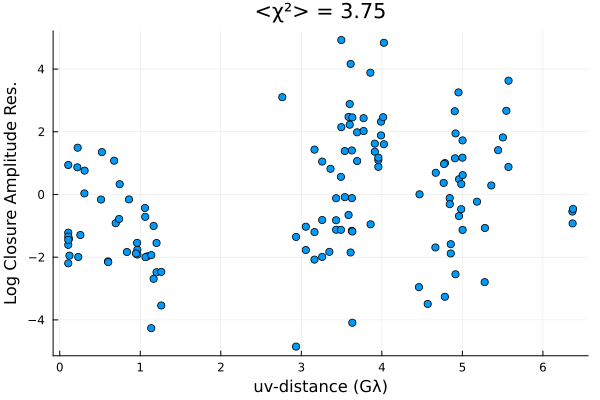

In [26]:
using Plots
using DisplayAs
p = residual(skymodel(post, xopt), dlcamp, ylabel="Log Closure Amplitude Res.")

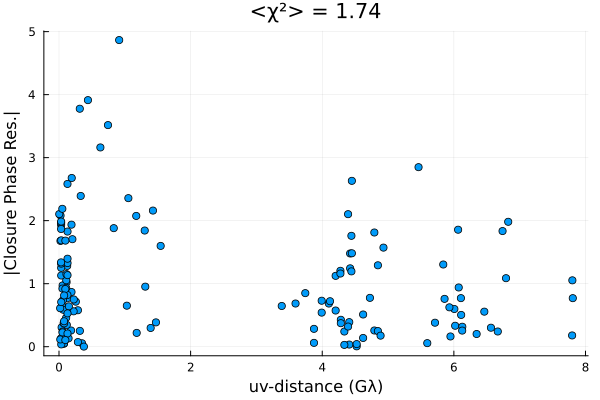

In [27]:
p = residual(skymodel(post, xopt), dcphase, ylabel="|Closure Phase Res.|")
DisplayAs.Text(DisplayAs.PNG(p))

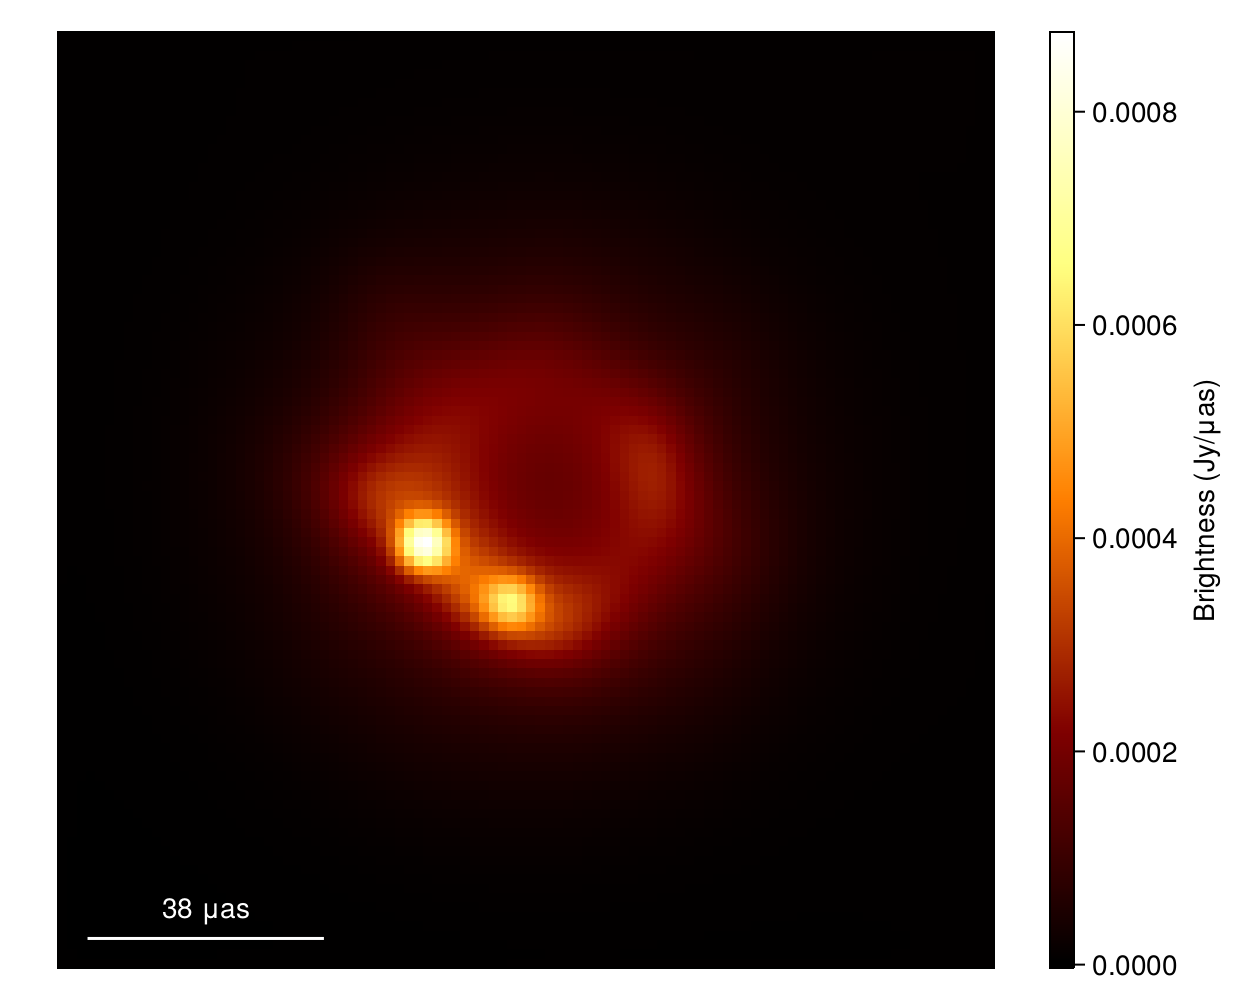

In [28]:
import CairoMakie as CM
img = intensitymap(skymodel(post, xopt), μas2rad(150.0), μas2rad(150.0), 100, 100)
fig = imageviz(img)

In [29]:
using ComradeAHMC
using Zygote
metric = DiagEuclideanMetric(ndim)
chain, stats = sample(post, AHMC(;metric, autodiff=Val(:Zygote)), 700; n_adapts=500, progress=false);

In [30]:
msamples = skymodel.(Ref(post), chain[501:2:end]);

In [31]:
using StatsBase
imgs = intensitymap.(msamples, μas2rad(150.0), μas2rad(150.0), 128, 128)
mimg = mean(imgs)
simg = std(imgs)
fig = CM.Figure(;resolution=(700, 700));
CM.image(fig[1,1], mimg,
                   axis=(xreversed=true, aspect=1, title="Mean Image"),
                   colormap=:afmhot)
CM.image(fig[1,2], simg./(max.(mimg, 1e-5)),
                   axis=(xreversed=true, aspect=1, title="1/SNR",), colorrange=(0.0, 2.0),
                   colormap=:afmhot)
CM.image(fig[2,1], imgs[1],
                   axis=(xreversed=true, aspect=1,title="Draw 1"),
                   colormap=:afmhot)
CM.image(fig[2,2], imgs[end],
                   axis=(xreversed=true, aspect=1,title="Draw 2"),
                   colormap=:afmhot)
CM.hidedecorations!.(fig.content)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/bread/.julia/packages/Makie/z2T2o/src/scenes.jl:220


4-element BitVector:
 0
 0
 0
 0

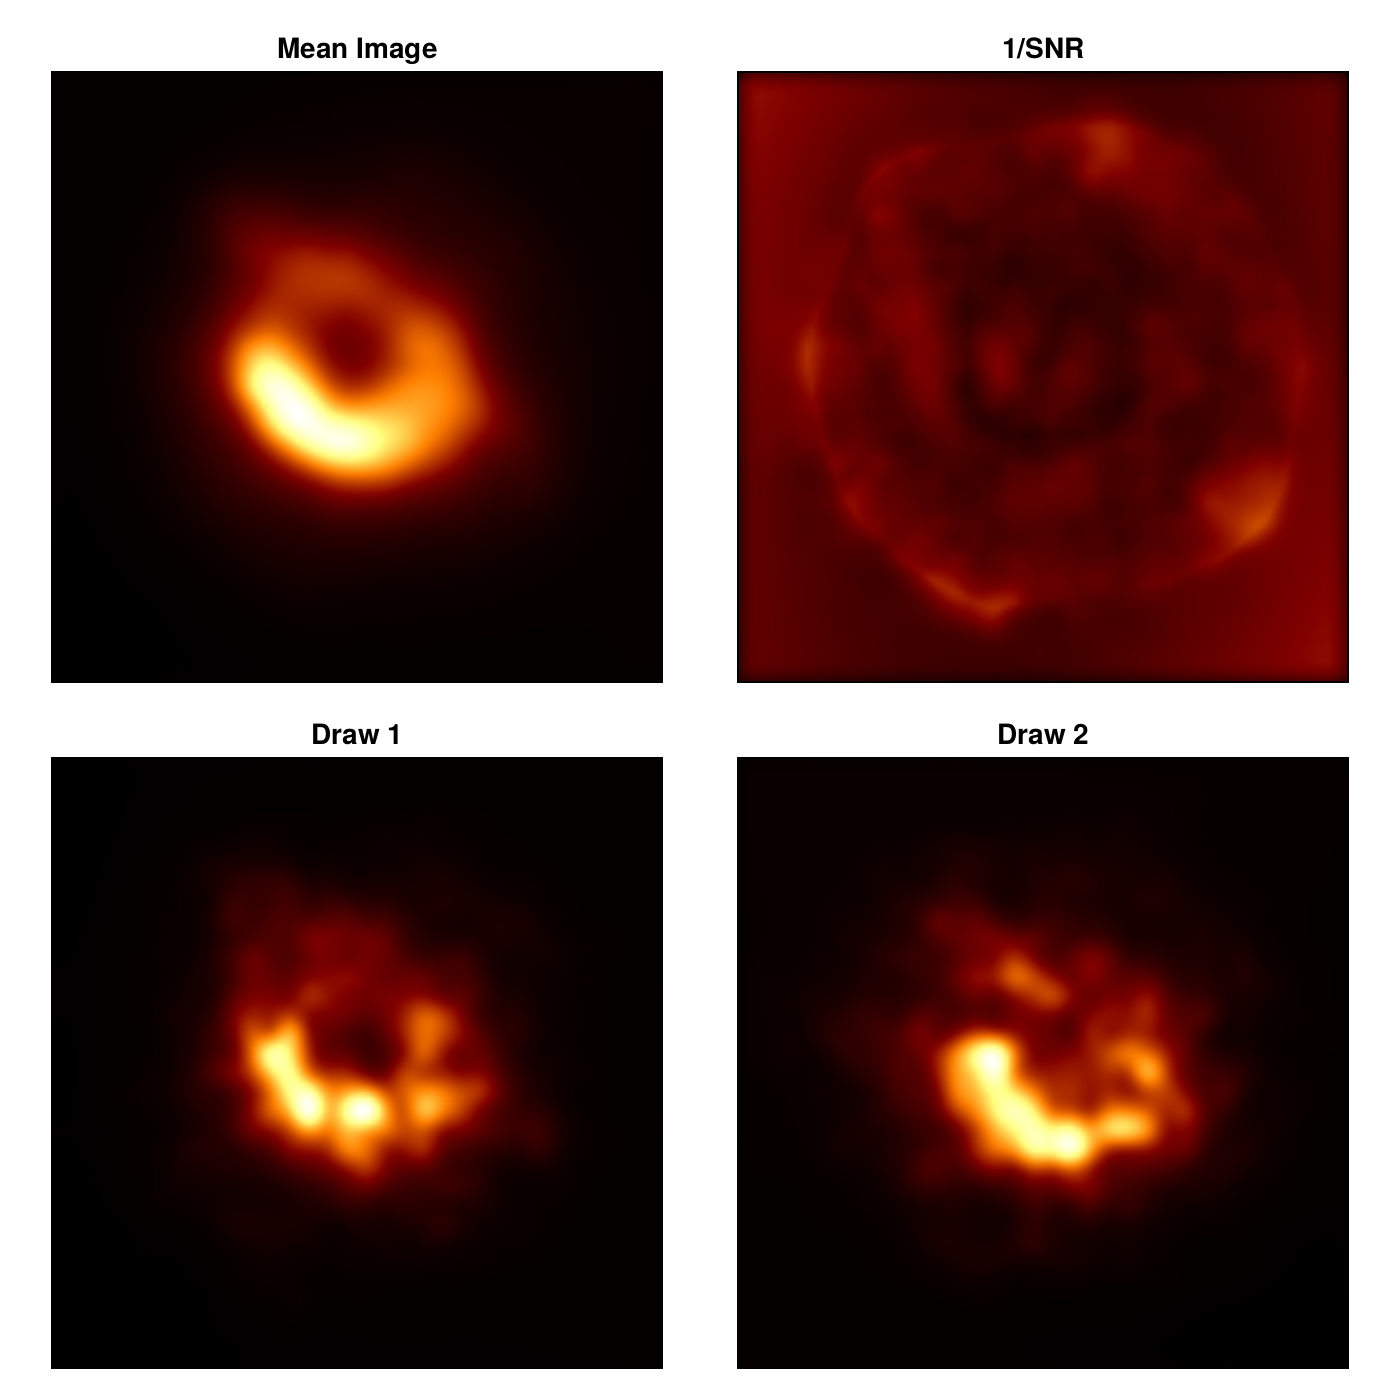

CairoMakie.Screen{IMAGE}


In [35]:
display(fig)

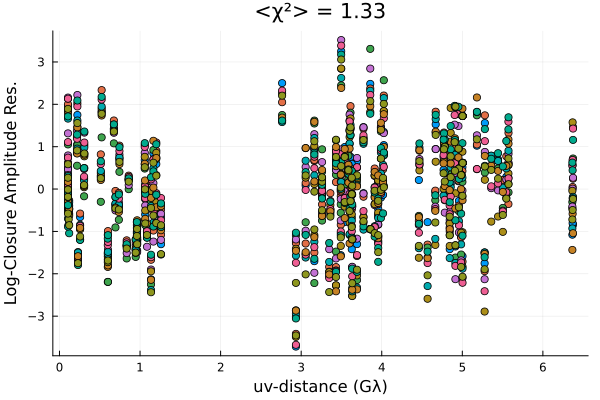

In [32]:
p = Plots.plot();
for s in sample(chain[501:end], 10)
    residual!(p, vlbimodel(post, s), dlcamp)
end
Plots.ylabel!("Log-Closure Amplitude Res.");
DisplayAs.Text(DisplayAs.PNG(p))

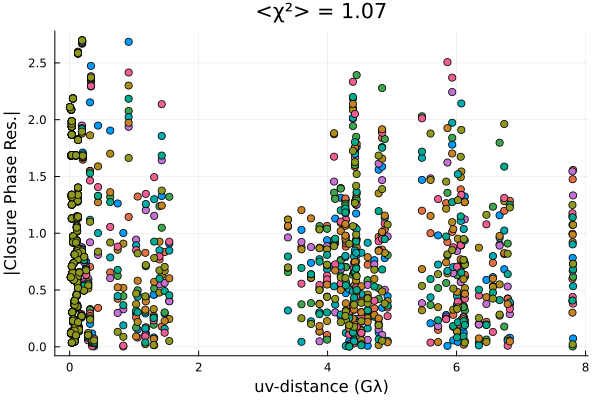

In [33]:
p = Plots.plot();
for s in sample(chain[501:end], 10)
    residual!(p, vlbimodel(post, s), dcphase)
end
Plots.ylabel!("|Closure Phase Res.|");
DisplayAs.Text(DisplayAs.PNG(p))